In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim + 1,))
# cond_label = keras.Input(shape=(1,))
# concat_input = tf.keras.layers.Concatenate()([latent_inputs, cond_label])
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(inputs=latent_inputs, outputs=decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              12544     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_______________________________________________________

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, combined_input):
        print(combined_input[0].shape)
        print(combined_input[1].shape)

        data = combined_input[0] # [0]
        label = combined_input[1]

        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            z_c = tf.keras.layers.concatenate([z, label])
            reconstruction = decoder(z_c)
            reconstruction_loss = tf.reduce_mean(
             keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss =  5*tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# New Section

In [ ]:
# Your input is here
import pandas as pd
data = pd.read_csv('ising_magnetization_data_wm100_img100_2')
data.head()
data_labels=np.array(data['0'])
temp = data_labels[0::100]
data_labels = np.expand_dims(data_labels , -1).astype("float32")
# drop the labels
data_wo_labels= data.drop(['Unnamed: 0','0'],axis=1)
data_in_array = np.array(data_wo_labels)
data_in_2d_arrays = data_in_array.reshape((-1, 28, 28, 1))
print(data_in_2d_arrays.shape)


(5000, 28, 28, 1)


In [ ]:
mcmc_mag_data=[]
for ising_picture in data_in_2d_Arrays:
  mag=0
  i=0
  while i < 100:
    x_decoded = np.array(decoder.predict(z_sample)).reshape(28*28)
    mag=np.abs(np.sum((2*x_decoded - 1)/(28*28))) + mag
    i=i+1
  mcmc_mag_data.append(mag/100)

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(data_in_2d_arrays, data_labels, epochs=30, batch_size=2)


Epoch 1/30
(2, 28, 28, 1)
(2, 1)
(2, 28, 28, 1)
(2, 1)
2500/2500 [==============================] - 8s 3ms/step - loss: 330.0016 - reconstruction_loss: 324.6798 - kl_loss: 5.3218
Epoch 2/30
2500/2500 [==============================] - 8s 3ms/step - loss: 320.2630 - reconstruction_loss: 317.3390 - kl_loss: 2.9240
Epoch 3/30
2500/2500 [==============================] - 8s 3ms/step - loss: 317.5865 - reconstruction_loss: 314.8354 - kl_loss: 2.7511
Epoch 4/30
2500/2500 [==============================] - 8s 3ms/step - loss: 315.7348 - reconstruction_loss: 312.4266 - kl_loss: 3.3082
Epoch 5/30
2500/2500 [==============================] - 8s 3ms/step - loss: 314.5961 - reconstruction_loss: 310.9391 - kl_loss: 3.6570
Epoch 6/30
2500/2500 [==============================] - 8s 3ms/step - loss: 313.7632 - reconstruction_loss: 310.0732 - kl_loss: 3.6900
Epoch 7/30
2500/2500 [==============================] - 8s 3ms/step - loss: 313.2531 - reconstruction_loss: 309.5955 - kl_loss: 3.6576
Epoch 8/30


# New Section

# Sampling

In [ ]:
import matplotlib.pyplot as plt
print(latent_dim)



4


In [ ]:
mag_data=[]
for t in temp:
  mag=0
  for i in range(100):
    z1=np.random.normal()
    z2=np.random.normal()
    z3=np.random.normal()
    z4=np.random.normal()
 

    z_sample = [[z1, z2, z3,z4, t]]
    x_decoded = np.array(decoder.predict(z_sample)).reshape(28*28)
    mag=np.abs(np.sum((2*x_decoded - 1)/(28*28))) + mag
  mag_data.append(mag/100)



In [ ]:
print(latent_dim)
print(mag_data)
def magnetization(t):
    return (1-(np.sinh(2/t)**(-4)))**(0.125)

4
[0.9888762527704239, 0.9900608783960343, 0.9545033930242062, 0.9960838681459427, 0.9526124024391174, 0.953731047809124, 0.9386083173006773, 0.9288858191668987, 0.9312700226902961, 0.9048939448595047, 0.8481781502068043, 0.8713400714099407, 0.7964109511673451, 0.7702041723579168, 0.7327368771284819, 0.6982679018378257, 0.6540468816831708, 0.6966112237796187, 0.5613489389792085, 0.5816463752649724, 0.5660333689767867, 0.5409201364777982, 0.47408397143241016, 0.45870746530592443, 0.4625542118027806, 0.4026751415990293, 0.309467731975019, 0.324694085130468, 0.33924218876287343, 0.23700287356972694, 0.25261937828734515, 0.2679621047433466, 0.22861700259149076, 0.2144544207304716, 0.17787641164846718, 0.17851546730846166, 0.14621160087175666, 0.18025520059280098, 0.20629661665763707, 0.14470727885141968, 0.13163104899344036, 0.15233136594295502, 0.12734762248583137, 0.12659863646142186, 0.12591680813115091, 0.10660404610913247, 0.1155614215368405, 0.09723675162065774, 0.089858515386004, 0.

In [ ]:
x_data = np.arange(.05,2.4,.01)
data_y = [magnetization(t) for t in x_data]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


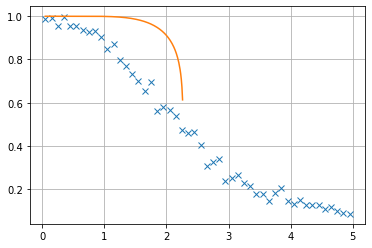

In [ ]:


plt.plot(temp,mag_data,'x',x_data,data_y,'-')
plt.grid()


0.6133708068629314
2.39
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 0.9999999999999997, 0.9999999999999984, 0.9999999999999933, 0.9999999999999747, 0.9999999999999133, 0.999999999999729, 0.9999999999992191, 0.9999999999979083, 0.9999999999947538, 0.9999999999875996, 0.9999999999722237, 0.99999999994075, 0.9999999998791212, 0.9999999997632348, 0.999999999553247, 0.9999999991854569, 0.9999999985610859, 0.999999997531198, 0.999999995876944, 0.9999999932842891, 0.9999999893123765, 0.9999999833547186, 0.9999999745924674, 0.999999961939117, 0.9999999439761121, 0.9999999188789853, 0.9999998843338125, 0.9999998374439512, 0.9999997746272086, 0.9999996915037649, 0.9999995827753502, 0.9999994420963321, 0.9999992619375149, 0.9999990334435692, 0.9999987462851143, 0.9999983885065458, 0.999997946370756, 0.9999974042019153, 0.9999967442274907, 0.9999959464206555, 0.9999949883442071, 0.9999938449970579, 0.9999924886642891, 0.9999908887716827, 0.9

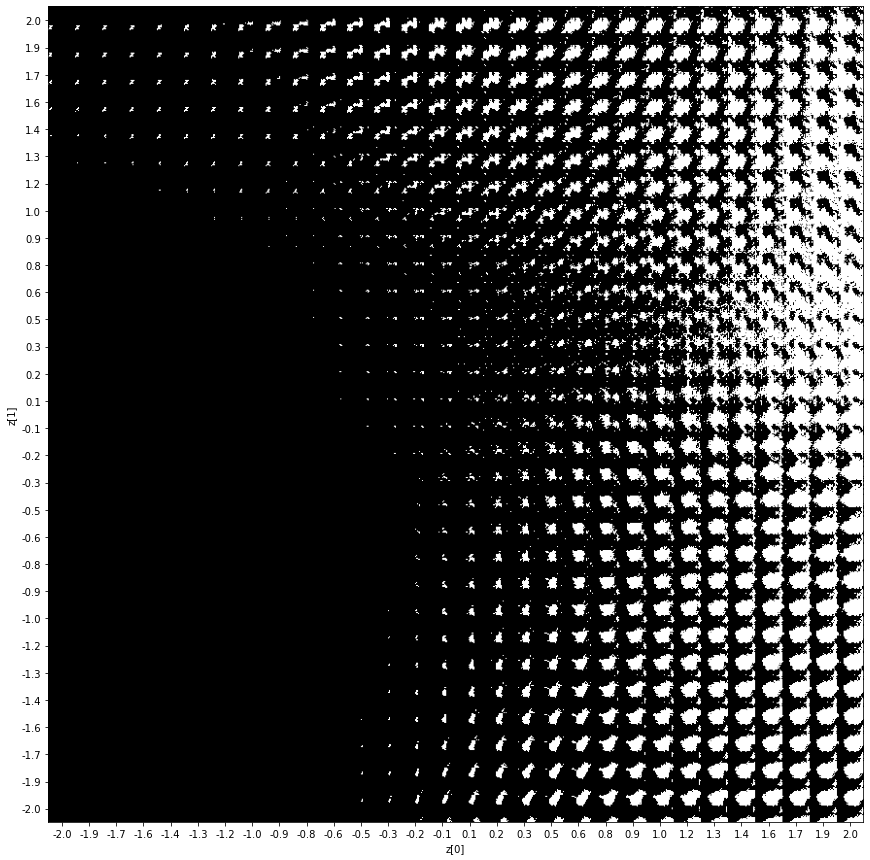

In [ ]:
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi,0.35]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(np.around(figure), cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)